In [6]:
import pdb
import pickle

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import radvel

import rvsearch
from rvsearch import utils

%matplotlib inline

# Make plots for ESS IV poster.

## Load all of the relevant data.

In [2]:
planets = pd.read_csv('planet_list_719.csv')
specmatch = pd.read_csv('legacy_tables/legacy_specmatch_medians.csv')

## Plot mass vs. semi-major-axis, one with MAP-values and one with MCMC medians & uncertainties.

In [3]:
planets_old = planets.query('status == "K"').reset_index()
planets_new = planets.query('status == "C" or status == "J"').reset_index()
print(len(planets_old))
print(len(planets_new))
print(len(planets_new.query('mass < 15')))

# Find the weird error outlier among the old planets.
#print(planets_old.query('mass_plus - mass_minus > 7 and mass_med < 40'))
#planets_new.query('axis > 3 and mass < 0.1')
planets_old.sort_values('axis')[['hostname', 'axis', 'axis_med', 'axis_minus','axis_plus']]

159
23
23


,hostname,axis,axis_med,axis_minus,axis_plus
142,gj3470,0.037420,3.741960e-02,3.699506e-02,3.783572e-02
80,219134,0.038460,3.846049e-02,3.797944e-02,3.892915e-02
103,46375,0.040095,4.009482e-02,3.956921e-02,4.060755e-02
62,187123,0.042075,4.207562e-02,4.124554e-02,4.287309e-02
58,179949,0.044251,4.425369e-02,4.364226e-02,4.484527e-02
151,bd-103166,0.045075,4.507814e-02,4.442071e-02,4.571325e-02
72,209458,0.046355,4.635294e-02,4.551682e-02,4.716253e-02
24,120136,0.048695,4.869493e-02,4.802363e-02,4.934845e-02
8,102195,0.048985,4.898068e-02,4.830531e-02,4.964485e-02
20,115617,0.049535,4.953386e-02,4.882060e-02,5.022650e-02


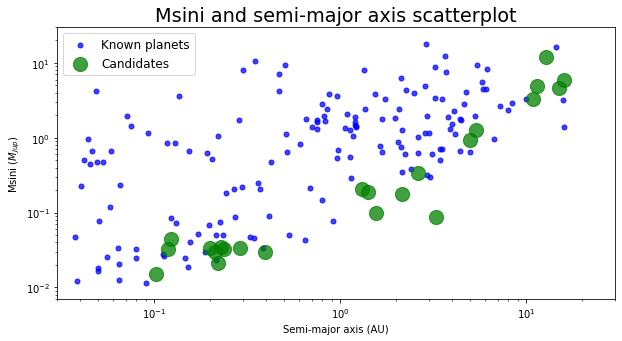

In [4]:
fig, ax = plt.subplots(figsize=(10, 5))
matplotlib.rcParams.update({'font.size': 16})
plt.title('Msini and semi-major axis scatterplot')
matplotlib.rcParams.update({'font.size': 12})
ax.scatter(planets_old.axis, planets_old.mass, c='b', alpha=0.75, label='Known planets')
ax.scatter(planets_new.axis, planets_new.mass, s=200, c='g', alpha=0.75, label='Candidates')
ax.set_xlim([3*10**-2, 30])
ax.set_ylim([7*10**-3, 30])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Semi-major axis (AU)')
ax.set_ylabel(r'Msini ($M_{Jup}$)')
ax.legend()

fig.savefig('Poster_plots/m_a_filter.png', dpi=500)

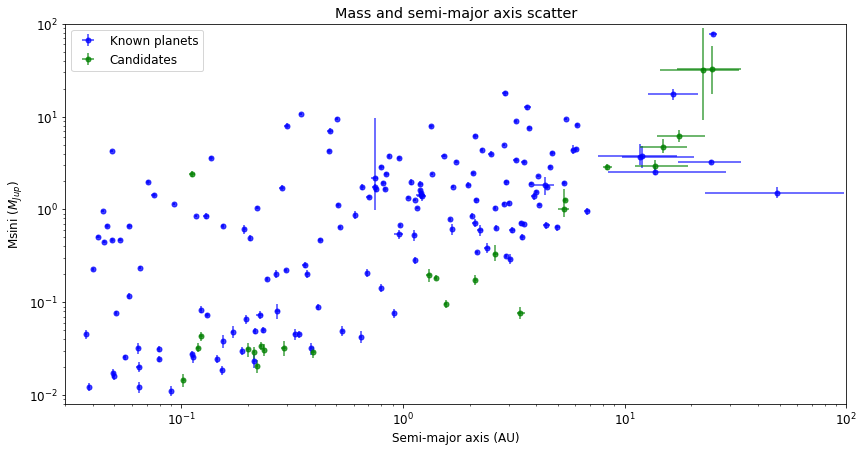

In [114]:
fig, ax = plt.subplots(figsize=(14, 7))
plt.title('Mass and semi-major axis scatter')

axerr_minus_old = planets_old.axis_med - planets_old.axis_minus
axerr_plus_old = planets_old.axis_plus - planets_old.axis_med
axerr_old = [axerr_minus_old, axerr_plus_old]
axerr_minus_new = planets_new.axis_med - planets_new.axis_minus
axerr_plus_new = planets_new.axis_plus - planets_new.axis_med
axerr_new = [axerr_minus_new, axerr_plus_new]

merr_minus_old = planets_old.mass_med - planets_old.mass_minus
merr_plus_old = planets_old.mass_plus - planets_old.mass_med
merr_old = [merr_minus_old, merr_plus_old]
merr_minus_new = planets_new.mass_med - planets_new.mass_minus
merr_plus_new = planets_new.mass_plus - planets_new.mass_med
merr_new = [merr_minus_new, merr_plus_new]

ax.errorbar(planets_old.axis_med, planets_old.mass_med, 
            xerr=axerr_old, yerr=merr_old, 
            fmt='o',c='b', alpha=0.75, label='Known planets')
ax.errorbar(planets_new.axis_med, planets_new.mass_med, 
            xerr=axerr_new, yerr=merr_new, 
            fmt='o',c='g', alpha=0.75, label='Candidates')

ax.set_xlim([3*10**-2, 10**2])
ax.set_ylim([8*10**-3, 10**2])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Semi-major axis (AU)')
ax.set_ylabel(r'Msini ($M_{Jup}$)')
ax.legend()
fig.savefig('Poster_plots/m_a_filter_errs.png', dpi=300)

## Plot planets over completeness contour.

In [7]:
#comp = Completeness(recoveries, mstar=None)
#cp = CompletenessPlots(comp)
complete_fig = pickle.load(open('Poster_plots/completeness_fig.pkl', 'rb'))

AttributeError: module 'ipykernel.pylab.backend_inline' has no attribute 'new_figure_manager_given_figure'

In [129]:
spec_emp = specmatch.query('teff_emp <= 4700')
spec_syn = specmatch.query('teff_emp > 4700')

In [151]:
specmatch.columns

Index(['Unnamed: 0', 'name', 'teff', 'teff_err', 'logg', 'logg_err', 'fe',
       'fe_err', 'vsini', 'vsini_err', 'iso_mass', 'iso_mass_err1',
       'iso_mass_err2', 'iso_radius', 'iso_radius_err1', 'iso_radius_err2',
       'iso_logage', 'iso_logage_err1', 'iso_logage_err2', 'iso_age',
       'iso_age_err1', 'iso_age_err2', 'iso_teff', 'iso_teff_err1',
       'iso_teff_err2', 'iso_logg', 'iso_logg_err1', 'iso_logg_err2', 'iso_fe',
       'iso_fe_err1', 'iso_fe_err2', 'teff_emp', 'teff_err_emp', 'radius_emp',
       'radius_err_emp', 'fe_emp', 'fe_err_emp'],
      dtype='object')

In [195]:
specmatch['name']

0       0748-01711-1
1              10002
2              10008
3             100180
4             100623
5             101259
6              10145
7             101501
8             102158
9             102195
10            103095
11            103432
12            103829
13            103932
14            104067
15            104304
16             10436
17            104556
18             10476
19            104800
20            105113
21            105618
22            105631
23            106116
24            106156
25            106315
26             10697
27             10700
28            107148
29             10780
           ...      
718         hip60633
719         hip63510
720         hip66459
721         hip67164
722         hip67285
723         hip70865
724         hip70975
725         hip71253
726         hip71898
727         hip74995
728         hip80295
729          hip8051
730         hip80824
731         hip83043
732         hip84099
733         hip84790
734         h

In [193]:
#teff_patch = np.concatenate(spec_syn['teff_emp'], spec_emp['teff_emp'])
#logg_patch = np.concatenate(spec_syn['iso_logg'], spec_emp['iso_logg'])

new_names = np.unique(planets_new['hostname'])

specmatch['status'] = 'K'

for index, row in planets_new.iterrows():
    name = row['hostname']
    specmatch.loc[specmatch['name'] == name]['status'] = 'C'
'''
for index, row in specmatch.iterrows():
    #print(index, row['name'])
    if row['name'][0] in new_names:
        print('True')
        specmatch[index, 'status'] = 'C'
'''        
        
np.unique(specmatch.status)
#specmatch_new = specmatch.loc[(specmatch.name in new_names).any()]
#specmatch_old = specmatch.query('name in planets_old.hostname')
#specmatch_new = specmatch.query('name in planets_new.hostname')

145675
111031
136925
141004
156668
161797
164922
164922
168009
190360
201092
213472
23439
24040
26161
3765
52265
66428
86728
95735
97101
97101
hip109388
tyc2597-735-1


array(['K'], dtype=object)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title('Stellar surface gravity and temperature')

ax.scatter(specmatch['teff_emp'], specmatch['iso_logg'], 
           alpha=0.66, s=7*np.exp(-3*specmatch['fe']),
           c='b', label='$\propto e^{-[Fe/H]}$')

ax.legend()
ax.set_xlabel('Teff (K)')
ax.set_ylabel('log(g) (cm/s$^2$)')
ax.set_ylim([4.9, 2.5])
ax.set_xlim([6700, 3000])

#print(cut['name teff logg fe vsini'.split()])
fig.savefig('Poster_plots/main_sequence_candidates.png', dpi=500)

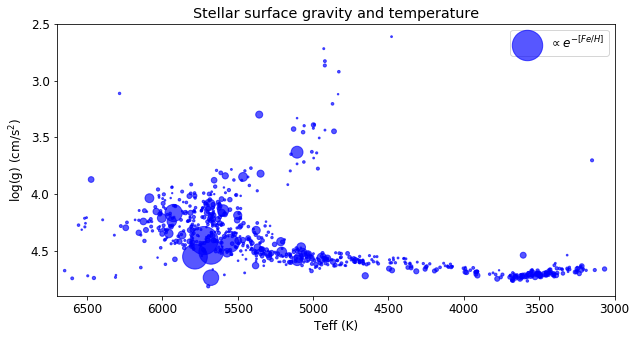

In [160]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title('Stellar surface gravity and temperature')

ax.scatter(spec_syn['teff_emp'], spec_syn['iso_logg'], 
           alpha=0.66, s=7*np.exp(-3*specmatch['fe']),
           c='b', label='$\propto e^{-[Fe/H]}$')
ax.legend()

ax.scatter(spec_emp['teff_emp'], spec_emp['iso_logg'], 
           s=7*np.exp(-3*spec_emp['fe_emp']), c='b', 
           alpha=0.66, label='Empirical')

ax.set_xlabel('Teff (K)')
ax.set_ylabel('log(g) (cm/s$^2$)')
ax.set_ylim([4.9, 2.5])
ax.set_xlim([6700, 3000])

#print(cut['name teff logg fe vsini'.split()])
fig.savefig('Poster_plots/main_sequence_polish.png', dpi=500)

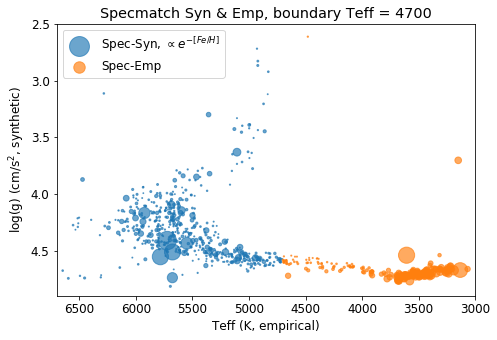

In [138]:
fig, ax = plt.subplots(figsize=(7.5, 5))

ax.scatter(spec_syn['teff_emp'], spec_syn['iso_logg'], 
           alpha=0.66, s=3*np.exp(-3*specmatch['fe']),
           label='Spec-Syn, $\propto e^{-[Fe/H]}$')

ax.set_title('Specmatch Syn & Emp, boundary Teff = 4700')
ax.scatter(spec_emp['teff_emp'], spec_emp['iso_logg'], 
           s=3*np.exp(-3*spec_emp['fe']), 
           alpha=0.66, label='Spec-Emp')
ax.set_xlabel('Teff (K, empirical)')
ax.set_ylabel('log(g) (cm/s$^2$, synthetic)')
ax.set_ylim([4.9, 2.5])
ax.set_xlim([6700, 3000])
ax.legend()

#print(cut['name teff logg fe vsini'.split()])
fig.savefig('Poster_plots/main_sequence_all.png', dpi=500)